#### Kriteriet er kopla til eit læringsmålData ready to use
(a) The final data is such that each row in the data corresponds to exactly 1 score that should be predicted.<br>
(b) The data does not leak any information (using player statistics of a given year to predict a score that happened in the same year).<br>
(c) The features in the final data are reasonable<br>

#### Kriteriet er kopla til eit læringsmålData description
(a) The different raw datasets as well as the combined datasets are described appropriately. <br>
(b) Some basic visualizations of the data that allows us to understand basic properties are available and explained.

#### Kriteriet er kopla til eit læringsmålReport
(a) The report is clear, well-written and understandable. <br>
(b) The code is readable and documented.<br>

### imports
imports all the models and libraries that i use aswell as the data that i use

In [1]:
# import pandas
import pandas as pd

# import files as dataframes, when you import from html you get a list of dataframes, so i need the [0]th element as there is only one element
games2017 = pd.read_html('prosjekt\\2017\\games.xls', encoding="UTF-8")[0]
games2018 = pd.read_html('prosjekt\\2018\\games.xls', encoding="UTF-8")[0]
games2019 = pd.read_html('prosjekt\\2019\\games.xls', encoding="UTF-8")[0]

#combines all the dataframes into one big one
raw_data = games2017.append(games2018).append(games2019)

#### cleaning the data
the first thing we need to do is to clean the data and make sure that it is usable<br>
i have to split the score into 2 different collumns and then remove NaN values from Score, Home and away because the data is useless when you dont know what the data is about

In [2]:
raw_data = raw_data.dropna(subset = ["Score", "Home", "Away"])
raw_data["Home score"] = raw_data["Score"].str[0:1].astype("int")
raw_data["Away score"] = raw_data["Score"].str[2:3].astype("int")
raw_data = raw_data.loc[:,["Date", "Home", "Home score", "Away score", "Away"]].reset_index(drop = True)

raw_data

,Date,Home,Home score,Away score,Away
0,2017-04-17,Medkila,1,1,Sandviken
1,2017-04-17,Avaldsnes,2,1,Vålerenga
2,2017-04-17,Grand Bodø,2,2,Arna-Bjørnar
3,2017-04-17,Røa,1,2,Stabæk
4,2017-04-17,LSK Kvinner,6,1,Klepp
...,...,...,...,...,...
393,2019-11-16,Kolbotn,0,0,Lyn
394,2019-11-16,Arna-Bjørnar,0,2,Vålerenga
395,2019-11-16,Fart,1,6,Klepp
396,2019-11-24,IF Fløya,0,5,Lyn


#### Formating the data
we have cleaned the data set in such a way that it only contains the values we intend to use. We can start making a new dataset with the same format as the input data. 
having propperly formated data also helps with visualization of the data.
because we want the same format as the input data we are going to need the collumns<br>
<ul>
    <li> ID to have a way to identify games </li>
    <li> Date to make sure we dont use games that happened in the future to predict games </li>
    <li> Season so we can add features from previous seasons </li>
    <li> Team so we can see who is playing </li>
    <li> Opponent so we can see who they are playing against </li>
    <li> Venue so we can see what team is at home and which is away</li>
</ul>
i am also adding 2 collumns which i am going to use for visualization and to teach the machine learning model, those collumns being:<br>
<ul>
    <li> Goals to teach the model to predict goals and to see if various aspects of the game affects the amount of goals in the visualization part of the task</li>
    <li> Winner is quite simmilar to the amount of goals but i intend to remove this feature before saving the dataframe as it cant be used in the prediction </li>
</ul>
when the data is formated like this we only get the score of one team, the one in the "team" collumn, so we are going to have to split each game into 2 rows which share the same id so that we can how many goals the teams score against the other 
   

In [3]:
clean_data = pd.DataFrame(columns=["ID","Date","Season","Team","Opponent","Venue", "Goals", "Winner"])

#this dict is to translate values from the raw data into the dataframe that has the same format as the input data

# my intention is to splitt the rows into 2, so that it says that 
# "x team played against y team at Home" and then "y team played agains x team Away"

for index, row in raw_data.iterrows():
        #finds out what the outcome of the match was 
    if(row["Away score"] > row["Home score"]):
        result = "Away"
    elif (row["Away score"] < row["Home score"]):
        result = "Home"
    else:
        result = "Draw"
    
    #this dict is to translate values from the raw data into the dataframe that has the same format as the input data
    home_dict = {
        "ID" : index,
        "Date" : row["Date"],
        "Season" : int(row["Date"][:4]),
        "Team" : row["Home"],
        "Opponent" : row["Away"],
        "Venue" : "Home",
        "Goals" : row["Home score"],
        "Winner" : result
     }

    away_dict = {
        "ID" : index,
        "Date" : row["Date"],
        "Season" : int(row["Date"][:4]),
        "Team" : row["Away"],
        "Opponent" : row["Home"],
        "Venue" : "Away",
        "Goals" : row["Away score"],
        "Winner" : result

    }
    
    #adds home vs away, then away vs home
    clean_data = clean_data.append(home_dict, ignore_index = True)
    clean_data = clean_data.append(away_dict, ignore_index = True)
    
clean_data

#this is the clean dataframe that we can use from now on out

,ID,Date,Season,Team,Opponent,Venue,Goals,Winner
0,0,2017-04-17,2017,Medkila,Sandviken,Home,1,Draw
1,0,2017-04-17,2017,Sandviken,Medkila,Away,1,Draw
2,1,2017-04-17,2017,Avaldsnes,Vålerenga,Home,2,Home
3,1,2017-04-17,2017,Vålerenga,Avaldsnes,Away,1,Home
4,2,2017-04-17,2017,Grand Bodø,Arna-Bjørnar,Home,2,Draw
...,...,...,...,...,...,...,...,...
791,395,2019-11-16,2019,Klepp,Fart,Away,6,Away
792,396,2019-11-24,2019,IF Fløya,Lyn,Home,0,Away
793,396,2019-11-24,2019,Lyn,IF Fløya,Away,5,Away
794,397,2019-12-01,2019,Lyn,IF Fløya,Home,2,Home


#### visualization
visualization can help quite a bit to find what factors to look upon when we want to make the machine learning model. when you visualize you have to find some factors that might be relevant to what you are working on. Some examples of factors that might affect how well a team plays is wether the team is playing at home or away and the average age of the people playing on the team. in this section i intend to look into some data that could be interesting to look at<br><br>
the first thing i am interested to look at is how the location of the game affects the outcome of the game.

Year,2017,2018,2019
Result,,,
Away,96,92,96
Draw,48,46,62
Home,120,126,110


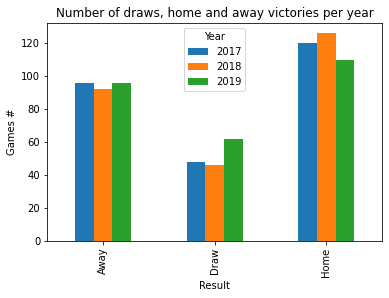

In [4]:
y2017 = clean_data.loc[clean_data["Season"] == 2017]
y2018 = clean_data.loc[clean_data["Season"] == 2018]
y2019 = clean_data.loc[clean_data["Season"] == 2019]

#making a new df that has the amount of home, away and draws as rows and the year as columns
df = y2017.groupby(["Winner"])[["Venue"]].count()
df["2018"] = y2018.groupby(["Winner"])[["Venue"]].count()
df["2019"] = y2019.groupby(["Winner"])[["Venue"]].count()
df = df.rename({'Venue': '2017'}, axis=1)
df = df.rename_axis("Result", axis="rows")
df = df.rename_axis("Year", axis="columns")

# makes the plot
fig = df.plot(ylabel = "Games #", kind = "bar", title = "Number of draws, home and away victories per year")
fig
df

from this graph we can see that the home team wins more often on average than the away team. this is also quite consistent between years, the greatest differance is between 2018 and 2019 where there were quite a few more draws and less home wins but there is still a conciderable differance between the amount of home wins than away wins. this makes me think that there is more to look into when it comes to the location of the match.
<br><br>
i proceed to look at how the amount of goals are affected hy the venue

Year,2017,2018,2019
Venue,,,
Away,190,191,188
Home,243,252,223


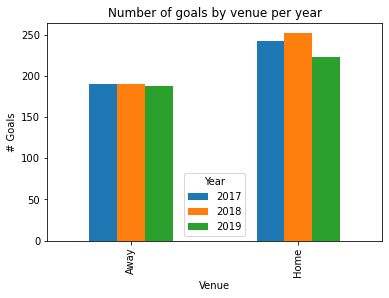

In [5]:
# this is the same that i did on the previous code box, but focusing on the amount of goals instead of the amount of victories
df = y2017.groupby(["Venue"])[["Goals"]].sum()
df["2018"] = y2018.groupby(["Venue"])[["Goals"]].sum()
df["2019"] = y2019.groupby(["Venue"])[["Goals"]].sum()

# renames axies and columns to make the DF and plot readable
df = df.rename({'Goals': '2017'}, axis=1)
df = df.rename_axis("Year", axis="columns")

fig = df.plot(ylabel = "# Goals", kind = "bar", title = "Number of goals by venue per year")
fig
df

as you can see the average amount of goals away is lower than the amount of goals at home. this result is consistent with what the last graph showed, so the team playing at home is likely to have an advantage over the team playing away meaning that we could most likely use this to predict the outcome of the match<br><br>

i want to use table.xls and team-stats.xls to to visualize how data affects the result

In [6]:
# imports the data from the tables
tables2017 = pd.read_html('prosjekt\\2017\\table.xls', encoding="UTF-8")[0]
tables2018 = pd.read_html('prosjekt\\2018\\table.xls', encoding="UTF-8")[0]
tables2019 = pd.read_html('prosjekt\\2019\\table.xls', encoding="UTF-8")[0]

# extracts the relevant data, there are no NaN values, so we dont have to remove them
position2017 = tables2017[["Rk", "Squad", "W", "D", "L", "GD", "Pts", "GF", "MP"]]
position2018 = tables2018[["Rk", "Squad", "W", "D", "L", "GD", "Pts", "GF", "MP"]]
position2019 = tables2019[["Rk", "Squad", "W", "D", "L", "GD", "Pts", "GF", "MP"]]

position2017["win_rate"] = position2017["W"]/position2017["MP"]
position2018["win_rate"] = position2018["W"]/position2018["MP"]
position2019["win_rate"] = position2019["W"]/position2019["MP"]

position2017

<ipython-input-6-6faf6655c472>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position2017["win_rate"] = position2017["W"]/position2017["MP"]
<ipython-input-6-6faf6655c472>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  position2018["win_rate"] = position2018["W"]/position2018["MP"]
<ipython-input-6-6faf6655c472>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Rk,Squad,W,D,L,GD,Pts,GF,MP,win_rate
0,1,LSK Kvinner,19,2,1,50,59,68,22,0.863636
1,2,Avaldsnes,15,3,4,34,48,51,22,0.681818
2,3,Stabæk,13,4,5,23,43,46,22,0.590909
3,4,Klepp,12,4,6,10,40,34,22,0.545455
4,5,Røa,11,4,7,14,37,42,22,0.500000
5,6,Arna-Bjørnar,9,8,5,11,35,39,22,0.409091
6,7,Vålerenga,10,4,8,5,34,38,22,0.454545
7,8,Trondheims-Ørn,8,6,8,0,30,36,22,0.363636
8,9,Sandviken,4,6,12,-11,18,23,22,0.181818
9,10,Kolbotn,4,3,15,-26,15,17,22,0.181818


In [7]:
# imports data
teams2017 = pd.read_html('prosjekt\\2017\\team-stats.xls', encoding="UTF-8")[0]
teams2018 = pd.read_html('prosjekt\\2018\\team-stats.xls', encoding="UTF-8")[0]
teams2019 = pd.read_html('prosjekt\\2019\\team-stats.xls', encoding="UTF-8")[0]

# the data has 2 levels which makes it tough to work with, so im dropping a level
teams2017.columns = teams2017.columns.droplevel()
teams2018.columns = teams2018.columns.droplevel()
teams2019.columns = teams2019.columns.droplevel()

# extracts the relevant data, there are no NaN values, so we dont have to remove them
teams2017 = teams2017[['Squad','Age', "G-PK"]]
teams2018 = teams2018[['Squad','Age', "G-PK"]]
teams2019 = teams2019[['Squad','Age', "G-PK"]]

teams2017

,Squad,Age,G-PK,G-PK
0,Arna-Bjørnar,22.0,36,1.64
1,Avaldsnes,25.5,48,2.18
2,Grand Bodø,22.7,29,1.32
3,Klepp,23.5,31,1.41
4,Kolbotn,21.9,16,0.73
5,LSK Kvinner,24.2,65,2.95
6,Medkila,20.9,9,0.41
7,Røa,22.8,42,1.91
8,Sandviken,24.4,23,1.05
9,Stabæk,25.5,44,2.00


In [8]:
# merges ages and the positions to get the relevant data
features2017 = teams2017.merge(position2017, left_on='Squad', right_on="Squad").sort_values("Rk")
features2018 = teams2018.merge(position2018, left_on='Squad', right_on="Squad").sort_values("Rk")
features2019 = teams2019.merge(position2019, left_on='Squad', right_on="Squad").sort_values("Rk")

features2017[["Squad", "Age", "Rk"]] = features2017[["Rk", "Squad", "Age"]]
features2018[["Squad", "Age", "Rk"]] = features2018[["Rk", "Squad", "Age"]]
features2019[["Squad", "Age", "Rk"]] = features2019[["Rk", "Squad", "Age"]]

features2017.columns = ["Rk", "Team", "G-PK", "G-PK90", "Age", "W", "D", "L", "GD", "Pts", "GF", "MP", "WR"]
features2018.columns = ["Rk", "Team", "G-PK", "G-PK90", "Age", "W", "D", "L", "GD", "Pts", "GF", "MP", "WR"]
features2019.columns = ["Rk", "Team", "G-PK", "G-PK90", "Age", "W", "D", "L", "GD", "Pts", "GF", "MP", "WR"]

features2017 = features2017.reset_index(drop = True).drop(["G-PK90", "MP"], axis = 1)
features2018 = features2018.reset_index(drop = True).drop(["G-PK90", "MP"], axis = 1)
features2019 = features2019.reset_index(drop = True).drop(["G-PK90", "MP"], axis = 1)

features2017

,Rk,Team,G-PK,Age,W,D,L,GD,Pts,GF,WR
0,1,LSK Kvinner,65,24.2,19,2,1,50,59,68,0.863636
1,2,Avaldsnes,48,25.5,15,3,4,34,48,51,0.681818
2,3,Stabæk,44,25.5,13,4,5,23,43,46,0.590909
3,4,Klepp,31,23.5,12,4,6,10,40,34,0.545455
4,5,Røa,42,22.8,11,4,7,14,37,42,0.500000
5,6,Arna-Bjørnar,36,22.0,9,8,5,11,35,39,0.409091
6,7,Vålerenga,38,25.8,10,4,8,5,34,38,0.454545
7,8,Trondheims-Ørn,36,22.1,8,6,8,0,30,36,0.363636
8,9,Sandviken,23,24.4,4,6,12,-11,18,23,0.181818
9,10,Kolbotn,16,21.9,4,3,15,-26,15,17,0.181818


now that we have imported the features we intend to use, we can proceed with using it to visualize it, the first thing i want to visualize is how the age affects the team rank at the end of the season

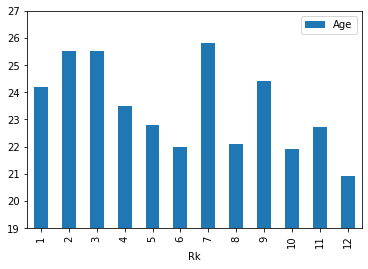

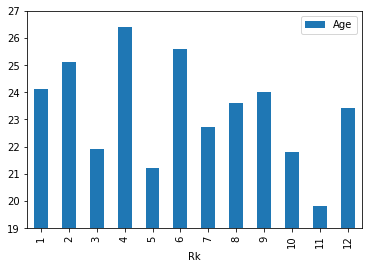

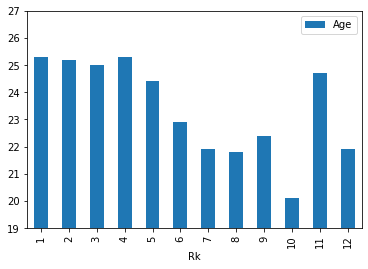

In [9]:
# plots the data, added ylim to make the data more readable
plt1 = features2017.plot(x="Rk", y="Age", kind = "bar", ylim = (19, 27))
plt2 = features2018.plot(x="Rk", y="Age", kind = "bar", ylim = (19, 27))
plt3 = features2019.plot(x="Rk", y="Age", kind = "bar", ylim = (19, 27))

these graphs show how the ranking of the team and the average age of the team members are related, you can see that the data varies a lot from year to year and that the average age of the ranks varies a lot. it is hard to use this data to predict anything because it is so inconsistent.
<br><br>
next i am going to look at the ammout of goals in total compared to the goal differance

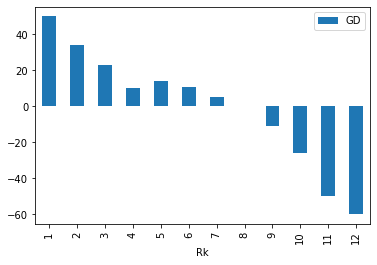

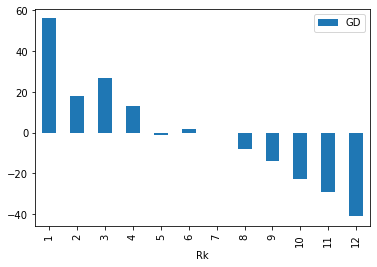

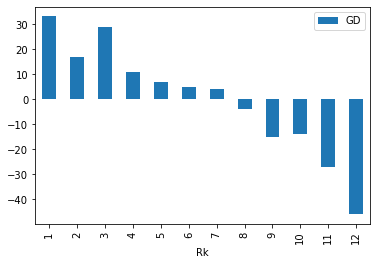

In [10]:
# plots the data
plt1 = features2017.plot(x="Rk", y="GD", kind = "bar")
plt2 = features2018.plot(x="Rk", y="GD", kind = "bar")
plt3 = features2019.plot(x="Rk", y="GD", kind = "bar")

here you can see that the goal difference is related to the position of the team. teams that did badly are those who are scored agains more than the opponent, and teams that did well scored more goals than the opponent.

This makes sense, so now we can look at whether it pays to play aggressively and score many goals, or defensively to score few goals since it is theoretically possible to win the entire cup by scoring 1:0 on every game.

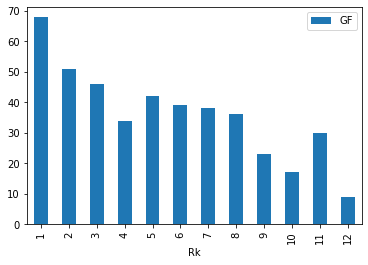

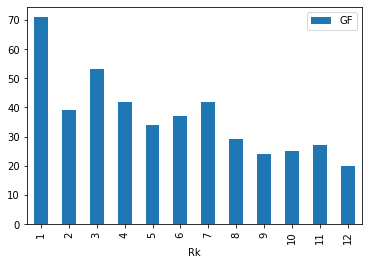

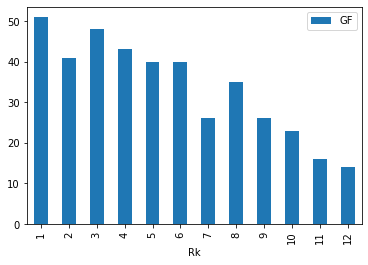

In [11]:
# plots the data
plt1 = features2017.plot(x="Rk", y="GF", kind = "bar")
plt2 = features2018.plot(x="Rk", y="GF", kind = "bar")
plt3 = features2019.plot(x="Rk", y="GF", kind = "bar")

here you see that it is those who get the most goals who do it best, there are some exceptions, such as 2nd place who score fewer goals on than the 3rd place every year, but in general it is those who score the most who win the cup. I interpret this as meaning that the offensive teams usually do better than the defensive teams.
<br><br>
I might aswell look at the Non-penalty goals while we are looking at goals

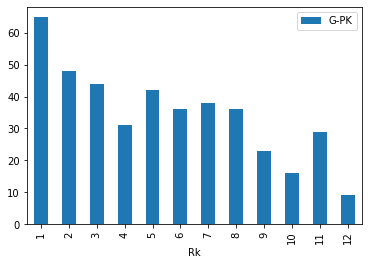

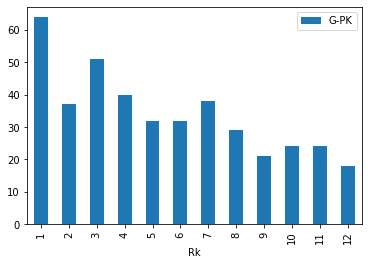

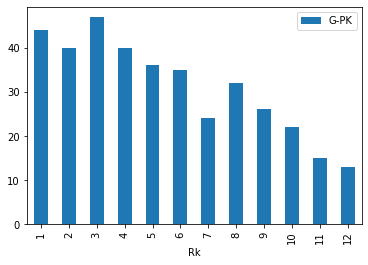

In [12]:
plt1 = features2017.plot(x="Rk", y="G-PK", kind = "bar")
plt2 = features2018.plot(x="Rk", y="G-PK", kind = "bar")
plt3 = features2019.plot(x="Rk", y="G-PK", kind = "bar")

this graph is pretty much exactly the same as goals, which is expected, but i might aswell include it as a feature since it is consistent with rank.

next feature we will take a look at is wins which i am going to predict is going to have a string corolation with the rank

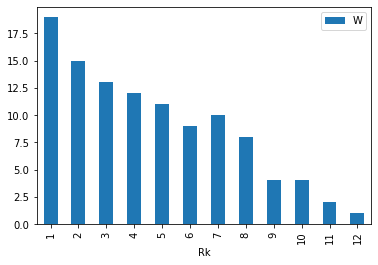

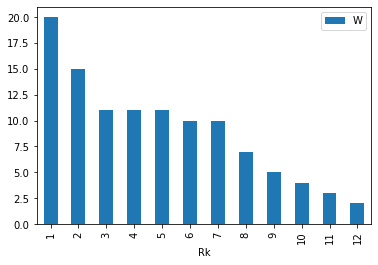

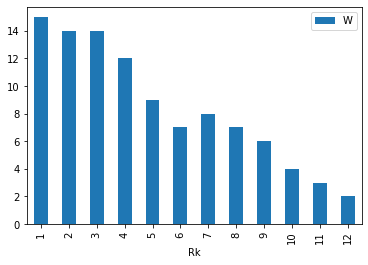

In [13]:
plt1 = features2017.plot(x="Rk", y="W", kind = "bar")
plt2 = features2018.plot(x="Rk", y="W", kind = "bar")
plt3 = features2019.plot(x="Rk", y="W", kind = "bar")

my assumption about wins and rank being closely related, there are some outliars which i assum is there because they got more draws and less losses than the person with the rank below.

next thing i will look at is draws, i am quite unsure if this is going to tell us that much about the result

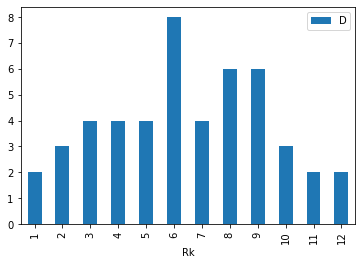

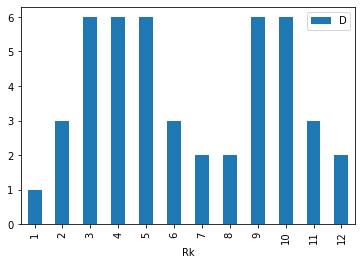

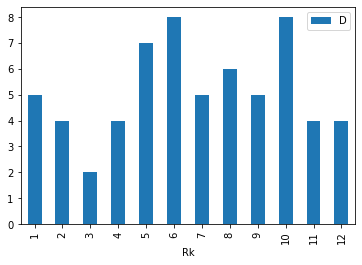

In [14]:
plt1 = features2017.plot(x="Rk", y="D", kind = "bar")
plt2 = features2018.plot(x="Rk", y="D", kind = "bar")
plt3 = features2019.plot(x="Rk", y="D", kind = "bar")

this seems very inconsistent, and i am not sure if i am going to keep it as a feature or not, ill see how it affects the results

its only logical to check out the losses then, and this should be pretty close to the inverse of wins

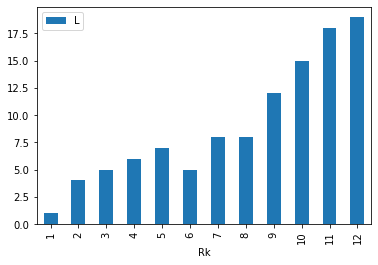

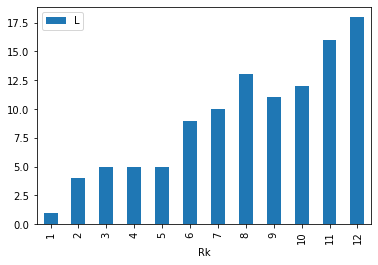

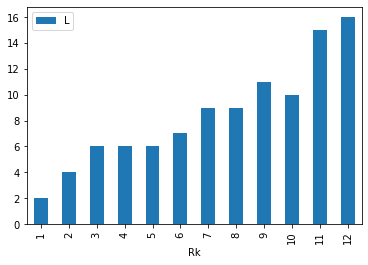

In [15]:
plt1 = features2017.plot(x="Rk", y="L", kind = "bar")
plt2 = features2018.plot(x="Rk", y="L", kind = "bar")
plt3 = features2019.plot(x="Rk", y="L", kind = "bar")

my assumptions about losses being close to the inverse of wins seems to be correct, so everything i said about wins applies to losses, but the opposite way
<br><br>

ill check out the amount of points by rank aswell, this should definitly be linear, but its going to be nice to see how the ranks are divided by points

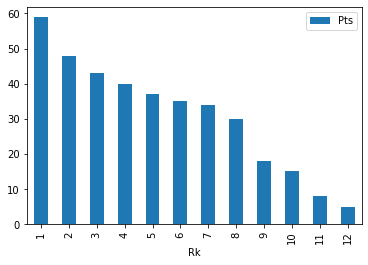

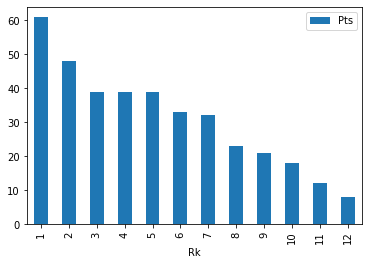

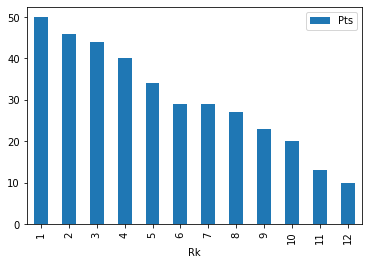

In [16]:
plt1 = features2017.plot(x="Rk", y="Pts", kind = "bar")
plt2 = features2018.plot(x="Rk", y="Pts", kind = "bar")
plt3 = features2019.plot(x="Rk", y="Pts", kind = "bar")

the data looks as expected, but there are some stuff that i want to comment on, and that is that there are some plateaus arround the middle of the ranks in all the years which is a bit interesting, but other than that, the data looks as expected and seems like quite a useful feature
<br><br>
last feature i intend to add is the win rate, this could help the prediction model quite a bit i believe.

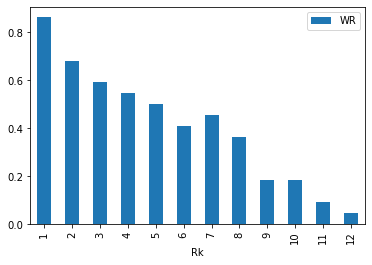

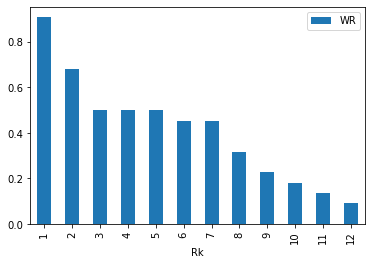

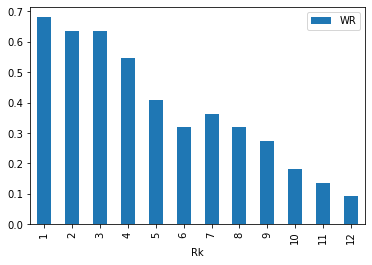

In [17]:
plt1 = features2017.plot(x="Rk", y="WR", kind = "bar")
plt2 = features2018.plot(x="Rk", y="WR", kind = "bar")
plt3 = features2019.plot(x="Rk", y="WR", kind = "bar")

this feature seems quite consistent aswell, and i think it could be quite useful for the prediction model
<br><br>
now i want to apply these features to the data so that it is a part of the prediction, ill also be applying these features to y2020 so that i dont have to do everything in the last step

In [18]:
y2020 = pd.read_csv("prosjekt//2020//test.csv", encoding = "UTF-8")

merged2018 = pd.merge(y2018, features2017, how = 'left', on=["Team"])
merged2019 = pd.merge(y2019, features2018, how = 'left', on=["Team"])
merged2020 = pd.merge(y2020, features2019, how = 'left', on=["Team"])

features2017o = features2017.rename(columns={"Team": "Opponent"})
features2018o = features2018.rename(columns={"Team": "Opponent"})
features2019o = features2019.rename(columns={"Team": "Opponent"})

merged2018 = pd.merge(merged2018, features2017o, how = 'left', on=["Opponent"])
merged2019 = pd.merge(merged2019, features2018o, how = 'left', on=["Opponent"])
y2020WithFeat = pd.merge(merged2020, features2019o, how = 'left', on=["Opponent"])

prepared_data = pd.concat([y2017, pd.concat([merged2018, merged2019])])

prepared_data = prepared_data.drop("Winner", axis = 1).reset_index(drop = True).fillna(0)
y2020WithFeat = y2020WithFeat.reset_index(drop = True).fillna(0)

y2020WithFeat.columns

Index(['ID', 'Date', 'Season', 'Team', 'Opponent', 'Venue', 'Rk_x', 'G-PK_x',
       'Age_x', 'W_x', 'D_x', 'L_x', 'GD_x', 'Pts_x', 'GF_x', 'WR_x', 'Rk_y',
       'G-PK_y', 'Age_y', 'W_y', 'D_y', 'L_y', 'GD_y', 'Pts_y', 'GF_y',
       'WR_y'],
      dtype='object')

In [19]:
prepared_data.to_csv("prepared_data.csv", index = False, encoding = "UTF-8")
y2020WithFeat.to_csv("prosjekt//2020//testwithfeat.csv", index = False, encoding = "UTF-8")
features2019.to_csv("FootballApp//data//features.csv", index = False, encoding = "UTF-8")